# scratch work

In [1]:
import jax

jax.config.update("jax_enable_x64", True)

import astropy.units as u
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.jplhorizons import Horizons
from numpy.polynomial import chebyshev
from tqdm import tqdm

from jorbit import Particle
from jorbit.astrometry.sky_projection import sky_sep
# from jorbit.utils.horizons import get_observer_positions


In [2]:
t0 = Time("2020-01-01")
forward_times = t0 + jnp.arange(0, 20.001, 10 * u.hour.to(u.year)) * u.year

forward_pos = jnp.load("src/jorbit/mpchecker/forward_pos.npy")

In [8]:
particle_name = "00075"


obj = Horizons(
            id=particle_name,
            location="500@0",
            epochs=t0.tdb.jd,
            id_type="smallbody",
        )
vecs = obj.vectors(refplane="earth")

# print("horizons vectors acquired")
x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]
# print("creating particle")
particle = Particle(x=x0, v=v0, time=t0, gravity="newtonian solar system")

t = forward_times.tdb.jd

In [9]:
# print("generating ephemeris")
eph = particle.ephemeris(t, observer=forward_pos)

In [15]:
# @jax.jit
def eval_cheby(coefficients, x):
    b_ii = jnp.zeros(2)
    b_i = jnp.zeros(2)

    def scan_func(X, a):
        b_i, b_ii = X
        tmp = b_i
        b_i = a + 2 * x * b_i - b_ii
        b_ii = tmp
        return (b_i, b_ii), b_i

    (b_i, b_ii), s = jax.lax.scan(scan_func, (b_i, b_ii), coefficients[:-1])
    return coefficients[-1] + x * b_i - b_ii, s

# @jax.jit
def _individual_state(init, intlen, coeffs, tdb):
    tdb2 = 0.0  # leaving in case we ever decide to increase the time precision and use 2 floats
    _, _, n = coeffs.shape

    # 2451545.0 is the J2000 epoch in TDB
    index1, offset1 = jnp.divmod((tdb - 2451545.0) * 86400.0 - init, intlen)
    index2, offset2 = jnp.divmod(tdb2 * 86400.0, intlen)
    index3, offset = jnp.divmod(offset1 + offset2, intlen)
    index = (index1 + index2 + index3).astype(int)

    omegas = index == n
    index = jnp.where(omegas, index - 1, index)
    offset = jnp.where(omegas, offset + intlen, offset)

    coefficients = coeffs[:, :, index]

    s = 2.0 * offset / intlen - 1.0

    (approx_ra, approx_dec), _ = eval_cheby(coefficients, s)  # in km here
    return approx_ra % (2*jnp.pi), approx_dec


In [55]:
t0 = Time("2020-01-01")
forward_times = t0 + jnp.arange(0, 20.001, 10*u.hour.to(u.year))*u.year
reverse_times = t0 - jnp.arange(0, 20.001, 10*u.hour.to(u.year))*u.year

forward_pos = jnp.load("forward_pos.npy")
reverse_pos = jnp.load("reverse_pos.npy")

In [56]:
forward_pos.shape


(17533, 3)

In [7]:
def generate_ephem(particle_name, chunk_size, degree):
    # chunk size in days

    obj = Horizons(id=particle_name, location="500@0", epochs=t0.tdb.jd)
    vecs = obj.vectors(refplane="earth")
    x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
    v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]
    particle = Particle(x=x0, v=v0, time=t0, gravity="newtonian solar system")

    t = forward_times.tdb.jd

    eph = particle.ephemeris(t, observer=forward_pos)

    r = jnp.unwrap(eph.ra.rad)
    d = eph.dec.rad

    num_chunks = int(jnp.ceil((t[-1] - t[0]) / chunk_size))

    init = (t[0] - 2451545.0) * 86400.0
    intlen = chunk_size * 86400.0

    coeffs = jnp.zeros((degree + 1, 2, num_chunks))
    for i in range(num_chunks):
        inds = (t >= t[0] + i * chunk_size) & (t < t[0] + (i + 1) * chunk_size)
        t_chunk = t[inds]
        r_chunk = r[inds]
        d_chunk = d[inds]

        # Scale time to [-1, 1] domain
        t_min, t_max = t0.tdb.jd + i * chunk_size, t0.tdb.jd + (i + 1) * chunk_size
        t_scaled = 2 * (t_chunk - t_min) / (t_max - t_min) - 1

        # Fit Chebyshev polynomials
        coefficients = chebyshev.chebfit(t_scaled, r_chunk, degree)
        coefficients = coefficients[::-1]
        coeffs = coeffs.at[:, 0, i].set(coefficients)

        coefficients = chebyshev.chebfit(t_scaled, d_chunk, degree)
        coefficients = coefficients[::-1]
        coeffs = coeffs.at[:, 1, i].set(coefficients)

    return init, intlen, coeffs



def test_ephem(particle_name, ephem, t):
    obj = Horizons(id=particle_name, location="500@399", epochs=t.utc.jd, id_type="smallbody")
    coord = obj.ephemerides(quantities=1, extra_precision=True)
    s = SkyCoord(coord["RA"], coord["DEC"], unit=(u.deg, u.deg))

    ra, dec = _individual_state(*ephem, t.tdb.jd)

    return sky_sep(ra, dec, s.ra.rad, s.dec.rad)


In [45]:
q = generate_ephem("737779", 10, 30, 10)

In [46]:
errs = []
for _i in tqdm(range(100)):
    delta = np.random.uniform(0, 20)
    t_test = t0 + delta * u.year
    err = test_ephem("737779", q, t0+delta*u.year)
    if err > 1.0:
        print(delta)
    errs.append(err)


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


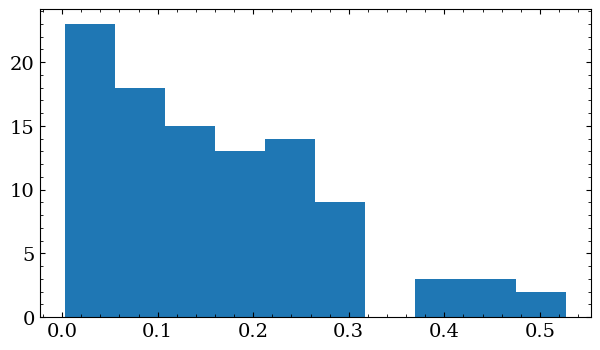

In [35]:
errs = jnp.array(errs)
plt.hist(errs);

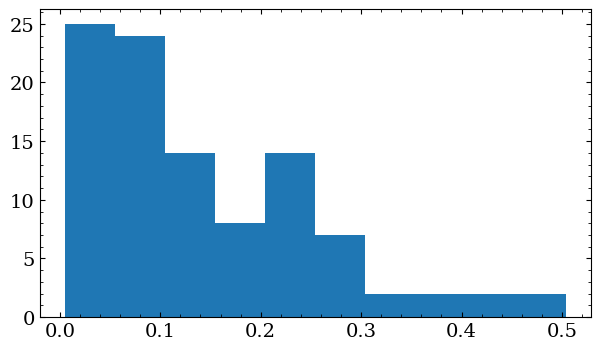

In [30]:
errs = jnp.array(errs)
plt.hist(errs);

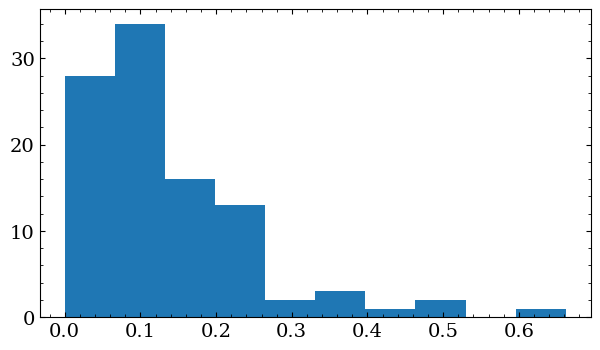

In [27]:
errs = jnp.array(errs)
plt.hist(errs);

In [51]:
from astropy.utils.data import download_file

download_file("https://zenodo.org/records/10161743/files/ERS_DataSynthesis_Zenodo.zip?download=1", cache=True)

'/Users/cassese/.astropy/cache/download/url/d130157051acdb2edae869c7ca04e3e8/contents'

In [41]:
from glob import glob

glob("/Users/cassese/.astropy/cache/download/url/d130157051acdb2edae869c7ca04e3e8/contents/*")

[]

In [42]:
import zipfile

with zipfile.ZipFile("/Users/cassese/.astropy/cache/download/url/d130157051acdb2edae869c7ca04e3e8/contents", 'r') as zip_ref:
    # Extract all contents
    zip_ref.extractall("/Users/cassese/.astropy/cache/download/url/d130157051acdb2edae869c7ca04e3e8/")

In [21]:
with open("src/jorbit/mpchecker/MPCORB.DAT") as f:
    lines = f.readlines()

num_jobs = 20_000
num_lines = int(jnp.ceil(len(lines) / num_jobs))


base = "uv run python contribute_to_ephem.py "
i = 43
with open("slurm_jobs_1.txt", "w") as f:
    for _j in range(10_000):
        if i + num_lines >= len(lines):
            end = len(lines)
            f.write(base + f"{i} {end}\n")
            break
        f.write(base + f"{i} {i+num_lines}\n")
        i += num_lines + 1

with open("slurm_jobs_2.txt", "w") as f:
    for _j in range(10_000, num_jobs):
        if i + num_lines >= len(lines):
            end = len(lines)
            f.write(base + f"{i} {end}\n")
            break
        f.write(base + f"{i} {i+num_lines}\n")
        i += num_lines + 1

In [17]:
a = np.array([
146.33,
147.14,
148.54,
150.98,
151.32,
151.74,
151.81,
152.34,
152.21,
152.79,
153.57,
153.68,
153.48,
154.93,
155.48,
155.36,
155.36,
155.96,
156.25,
155.74,
156.40,
156.50,
156.78,
157.55,
159.15,
159.71,
161.63,
152.98,
153.23,
162.63,
153.33,
153.34,
153.34,
153.41,
153.88,
154.92,
164.88,
165.96,
157.13,
166.55,
157.65,
166.64,
159.16,
160.92,
170.09,
170.58,
170.80,
171.42,
172.43,
172.85,
161.98,
174.45,
174.51,
174.72,
176.56,
176.91,
176.86,
173.15,
175.05,
122.30,
122.30,
123.85,
155.49,
123.94,
155.63,
155.79,
156.24,
157.03,
157.15,
157.99,
158.76,
127.90,
128.21,
128.83,
128.45,
129.25,
129.32,
129.62,
161.47,
130.06,
131.43,
131.52,
181.11,
169.91,
200.01,
140.71,
141.18,
144.79,
166.88,
167.12,
145.10,
204.91,
181.31,
212.45,
170.86,
171.05,
172.09,
171.76,
214.88,
215.49,
158.64,
218.10,
218.66,
219.19,
191.24,
219.59,
219.76,
220.14,
192.84,
184.37,
185.37,
222.30,
195.40,
223.34,
224.27,
224.19,
225.33,
227.63,
227.98,
228.51,
180.99,
181.97,
182.35,
242.86,
242.95,
243.50,
243.50,
243.63,
244.18,
244.16,
244.26,
243.77,
244.16,
175.63,
179.86,
177.59,
222.89,
173.51,
245.25,
160.37,
162.02,
161.95,
161.63,
165.09,
163.70,
162.19,
129.74,
137.09,
137.18,
130.92,
247.11,
178.20,
178.22,
223.40,
223.84,
178.93,
179.35,
179.44,
179.74,
180.02,
180.14,
190.88,
190.90,
190.92,
190.45,
191.42,
165.71,
166.27,
169.69,
167.74,
234.09,
206.31,
206.72,
206.98,
181.24,
182.32,
138.02,
251.06,
140.54,
142.30,
199.45,
224.43,
197.23,
224.80,
285.24,
214.31,
221.98,
216.61,
258.62,
259.59,
286.96,
287.44,
287.78,
260.62,
260.67,
191.62,
194.82,
288.46,
260.89,
229.39,
239.23,
239.25,
239.24,
230.66,
170.27,
232.06,
170.73,
171.11,
171.20,
171.23,
171.24,
171.25,
171.35,
171.54,
171.59,
171.83,
264.42,
172.18,
172.38,
172.44,
172.57,
172.72,
173.46,
174.09,
175.04,
267.34,
270.30,
149.68,
244.96,
244.50,
245.37,
248.38,
157.05,
311.49,
311.52,
311.89,
149.33,
228.66,
232.88,
258.93,
259.63,
292.91,
292.91,
147.30,
149.46,
151.84,
152.59,
152.62,
152.71,
152.68,
152.79,
152.96,
153.25,
152.79,
153.82,
153.80,
154.16,
154.27,
154.19,
154.26,
154.62,
154.94,
154.96,
155.55,
155.56,
155.64,
156.43,
156.82,
156.83,
158.31,
338.69,
339.21,
339.58,
339.63,
339.74,
340.06,
341.96,
162.11,
164.10,
165.15,
165.31,
166.23,
168.03,
169.10,
262.19,
169.60,
169.78,
169.92,
170.57,
171.88,
172.04,
172.63,
173.45,
173.68,
174.09,
174.48,
224.87,
138.63,
139.12,
203.69,
3.49,
139.43,
139.57,
139.57,
140.55,
140.60,
140.88,
227.82,
159.84,
164.83,
159.75,
157.65,
128.04,
142.04,
228.53,
157.25,
160.23,
159.97,
160.01,
228.90,
130.01,
230.67,
230.69,
234.62,
235.06,
235.66,
235.75,
134.19,
236.58,
237.11,
132.74,
133.67,
149.41,
137.10,
136.56,
306.35,
307.60,
311.07,
313.37,
311.90,
139.74,
140.74,
141.90,
324.60,
324.62,
226.71,
228.19,
226.71,
227.93,
229.88,
226.71,
226.93,
228.17,
292.72,
292.74,
153.80,
153.85,
228.61,
231.23,
230.54,
228.35,
242.15,
242.15,
154.89,
382.23,
383.28,
382.66,
383.73,
385.15,
385.10,
387.65,
383.21,
383.50,
381.62,
384.32,
385.17,
242.58,
155.19,
155.74,
156.50,
156.67,
156.75,
159.25,
399.69,
327.84,
330.77,
331.43,
332.35,
330.90,
400.36,
400.39,
401.00,
161.33,
251.26,
402.69,
402.65,
164.60,
404.03,
404.91,
166.68,
406.34,
169.63,
169.78,
249.12,
174.28,
115.44,
114.97,
116.84,
117.18,
117.27,
117.51,
116.96,
117.76,
119.39,
118.04,
169.15,
170.91,
172.58,
116.96,
164.83,
128.91,
129.28,
129.32,
129.00,
129.20,
167.58,
135.24,
136.83,
137.82,
139.00,
142.21,
141.69,
142.87,
190.07,
143.41,
142.90,
190.82,
236.84,
240.42,
238.74,
147.82,
183.76,
402.05,
403.61,
403.57,
152.83,
153.11,
189.16,
153.16,
214.84,
154.31,
153.88,
154.20,
155.50,
155.51,
155.64,
155.02,
155.84,
216.44,
157.06,
218.06,
218.05,
157.35,
218.71,
218.72,
219.09,
219.61,
219.97,
158.72,
159.30,
220.73,
221.72,
461.33,
409.97,
409.88,
169.68,
170.43,
225.54,
164.61,
164.73,
171.47,
165.21,
226.56,
165.91,
166.11,
172.70,
166.90,
167.11,
167.35,
167.28,
167.34,
167.47,
229.17,
167.76,
229.48,
168.31,
168.00,
168.94,
169.18,
230.59,
169.28,
170.39,
170.50,
172.00,
171.64,
129.26,
129.69,
167.11,
134.74,
395.94,
397.60,
398.13,
398.68,
397.31,
399.59,
396.74,
400.72,
400.01,
397.42,
396.81,
399.38,
396.69,
136.69,
242.38,
242.48,
242.57,
242.80,
242.91,
242.94,
243.05,
243.12,
243.32,
243.57,
407.73,
408.40,
409.25,
409.24,
408.19,
243.64,
391.49,
393.31,
393.27,
169.84,
183.21,
170.61,
305.15,
305.19,
170.80,
415.07,
414.43,
414.75,
414.16,
414.05,
411.05,
413.01,
415.29,
417.22,
413.14,
417.11,
411.90,
123.96,
124.25,
185.38,
124.72,
125.16,
175.25,
436.74,
437.42,
437.74,
437.76,
437.95,
438.03,
438.06,
438.13,
191.70,
144.61,
192.44,
348.01,
350.10,
354.54,
349.96,
349.10,
353.85,
349.36,
348.09,
348.34,
355.31,
350.54,
350.02,
192.89,
147.68,
148.27,
196.50,
196.38,
453.56,
454.58,
457.13,
457.26,
454.57,
150.26,
150.73,
151.19,
151.20,
151.62,
213.67,
203.59,
214.49,
153.26,
153.27,
153.54,
153.80,
153.93,
154.80,
154.95,
155.25,
155.09,
155.17,
155.17,
155.58,
155.53,
205.10,
208.45,
208.47,
207.71,
208.02,
207.86,
156.28,
117.32,
156.36,
156.63,
156.70,
218.34,
157.07,
156.89,
144.88,
265.08,
157.59,
220.46,
132.99,
133.17,
138.43,
132.99,
134.13,
132.99,
137.98,
160.55,
222.43,
161.51,
173.99,
166.91,
442.02,
167.00,
167.14,
167.34,
168.43,
495.53,
495.58,
495.55,
495.57,
495.55,
168.51,
168.59,
176.38,
169.39,
160.76,
170.37,
160.90,
161.33,
171.10,
161.70,
178.87,
171.63,
163.72,
164.14,
181.03,
173.50,
174.96,
136.17,
175.29,
459.28,
459.33,
459.33,
459.54,
459.77,
459.86,
460.42,
460.58,
460.72,
460.84,
460.85,
460.92,
461.04,
355.27,
355.33,
358.11,
461.22,
221.24,
221.50,
244.71,
245.62,
346.55,
348.39,
246.84,
392.15,
393.83,
397.71,
394.56,
395.39,
392.29,
397.00,
392.49,
391.07,
392.85,
396.25,
394.97,
153.14,
153.50,
153.66,
473.53,
473.53,
473.53,
154.21,
155.99,
243.53,
156.23,
156.30,
159.31,
163.04,
156.73,
156.76,
156.79,
248.39,
227.85,
481.69,
228.34,
228.55,
385.40,
191.51,
242.86,
493.75,
495.21,
496.97,
494.50,
498.75,
244.56,
487.87,
159.39,
159.39,
160.80,
159.46,
161.28,
159.86,
211.46,
211.69,
156.51,
157.04,
156.55,
156.66,
212.74,
215.08,
264.28,
264.32,
264.62,
266.08,
265.99,
500.26,
500.28,
223.19,
223.54,
223.55,
525.31,
525.86,
526.74,
526.89,
527.16,
527.46,
527.76,
407.84,
528.51,
409.54,
590.51,
256.95,
257.48,
257.78,
533.43,
533.57,
533.76,
533.45,
335.65,
342.25,
336.31,
337.17,
337.17,
338.52,
340.73,
335.98,
341.30,
337.59,
418.41,
418.52,
419.12,
419.17,
238.72,
240.07,
225.62,
420.95,
421.19,
421.87,
423.27,
243.16,
425.26,
])

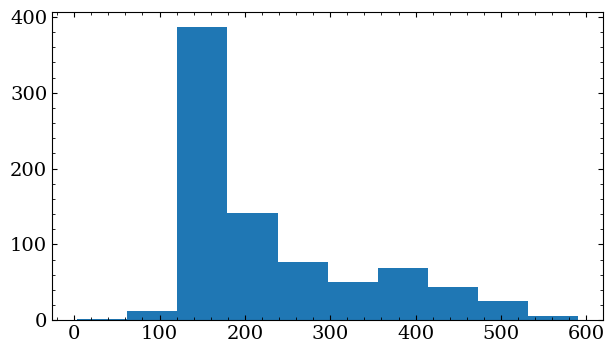

In [18]:
plt.hist(a);

In [22]:
(600/5)*72*u.s.to(u.min)

144.0